In [1]:
import numpy as np
import pandas as pd
import nltk  
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import sys
import re
import html
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_selection import SelectKBest

from warnings import filterwarnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline 

In [1]:
from nltk.corpus import stopwords
# stopWords = set(stopwords.words('english'))

In [3]:
###setting 
np.set_printoptions(threshold=sys.maxsize)



In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/jianhuili/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
df_election=pd.read_csv('Canadian_elections_2019.csv')
null_columns=df_election.columns[df_election.isnull().any()]
df_election[null_columns].isnull().sum()




negative_reason    1126
dtype: int64

In [6]:
df_election.shape

(2133, 3)

In [7]:
df_election['text'][2000]

"b'Voting more than once is against the law. You can face a fine of up to $50 000 or up to 5 years in jail or both. \\n\\n#cdnpoli #elxn43 #electionsact #DYK https://t.co/RQdkkqZ1Am'"

In [8]:
df_sentiment=pd.read_csv('Sentiment.csv')

null_columns=df_sentiment.columns[df_sentiment.isnull().any()]
df_sentiment[null_columns].isnull().sum()



text    14
dtype: int64

make sure the sentiment dataframe without any null data

In [9]:
df_sentiment.dropna(inplace=True)

In [10]:
df_sentiment.text[1]

"@chiefy74 Damn i'm jealous, i wanna watch the fight  i love ufc just no one knows."

In [11]:
df_sentiment.head()

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


In [12]:
df_sentiment.shape

(133797, 2)

# 1. Data Cleaning

In [13]:
# readstop word file, and save it
with open('stop_words.txt','r') as f:
    stop_words = f.read().split('\n')

o All html tags and attributes (i.e., /<[^>]+>/) are removed.
o Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
o All URLs are removed.
o All characters in the text are in lowercase.
o All stop words are removed. Be clear in what you consider as a stop word. o If a tweet is empty after pre-processing, it should be preserved as such

### 1.1 All html tags and attributes removed

In [14]:
def clean(string):
    term=re.sub(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+', ' ', string)
    term=re.sub(r'\s*<.*?>',' ',term) #Remove html tags and attributes in form of <...>
    term = re.sub("<'b\'>", "",term)# remove b\
    term=re.sub(r'[^\w]', ' ', term)
    term=re.sub("r'?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?[\]@!\$&\'\(\)\*\+,;=.]+'"," ",term)
    term =re.sub(r'[\n\r\t]',' ',term)
    term =re.sub( r"[^\s\w]+",' ',term) # Remove non alphanumeric characters except space
    term=re.sub(r'[^\w]', ' ', term)
    term=re.sub(r'\s[x][a-z\d]{2}', ' ', term)
    term = re.sub(r"(\s\d+)", ' ', term)  # remove pure numbers
    # remove the website link and URL
   
    return term
    

### 1.2 Html character codes  are replaced with an ASCII equivalent


In [15]:
def replace_html(string):
    data=html.escape(string) #Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
   
     #then remove the unwanted 
#     term=re.sub(r'www\S+', '', data)
#     term=re.sub('http[s]?://\S+', '', term)
    return data

### 1.3 remove stopwords

In [16]:
def remove_stopword(data):
#     data=data.apply(lambda x: [word for word in x if word not in stopwords.words('english')])
    
    words_rmStop = [word for word in b if word not in stop_words]
    return words_rmStop

### 1.4 All characters in the text are in lowercase, and remove stopwords

In [17]:
df_election['text_clean']=df_election['text'].str.lower()
df_election['text_clean']=df_election['text_clean'].apply(replace_html)
df_election['text_clean']=df_election['text_clean'].apply(clean)

### 1.5 All stop words are removed
### tokenizer ot reform our text data

In [18]:

tokenizer = RegexpTokenizer(r'\w+')
df_election['text_clean']=df_election['text_clean'].apply(lambda data: tokenizer.tokenize(data))
df_election['text_clean']=df_election['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
df_election['text_clean']=df_election['text_clean'].apply(lambda x:' '.join(x))

### show the Canadian_elections_2019.csv  after pre-processing

In [19]:
df_election.head()

,sentiment,negative_reason,text,text_clean
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",quot rosiebarton suggestion agree canadian wom...
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",quot allwomanspacewalk real space_station etob...
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",quot brantford going cost billion years justin...
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",quot canada canadaelection2019 canadavotes elx...
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",quot canada taxpayers sick amp amp tired hard ...


### modify sentiment text data

In [20]:
df_sentiment['text_clean']=df_sentiment['text'].str.lower()
df_sentiment['text_clean']=df_sentiment['text_clean'].apply(replace_html)
df_sentiment['text_clean']=df_sentiment['text_clean'].apply(clean)

In [21]:


tokenizer = RegexpTokenizer(r'\w+')
df_sentiment['text_clean']=df_sentiment['text_clean'].apply(lambda data: tokenizer.tokenize(data))
df_sentiment['text_clean']=df_sentiment['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
df_sentiment['text_clean']=df_sentiment['text_clean'].apply(lambda x:' '.join(x))


In [22]:
df_sentiment.head()
null_columns=df_sentiment.columns[df_sentiment.isnull().any()]
df_sentiment[null_columns].isnull().sum()
print(df_sentiment[df_sentiment.isnull().any(axis=1)][null_columns].head())


Empty DataFrame
Columns: []
Index: []


### Final : show the Sentiment.csv after pre-processing

In [23]:
df_sentiment.head()

,sentiment,text,text_clean
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,rt diplomtc_immnty realdonaldtrump amp amp pol...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",chiefy74 damn jealous wanna watch fight love ufc
2,Positive,I'm listening The Beatles now. They're great,listening beatles great
3,Positive,@ddlovato could i please get a shout out or an...,ddlovato shout huge fan t wait cd
4,Positive,@salspizza just spotted ur message there Tony ...,salspizza spotted ur message tony replied


In [24]:
# string=df_election['text'][1]

In [25]:
# string

In [26]:
# string=string.replace('\\n',' ')

In [27]:
# string=re.sub(r'[b]\"|[b]\'',' ',string)

# 2. Exploratory Analysis

### 2.1 obtain hashtags
Hash Tag Strategy: 1.Find the single word after @ and # symbol:these two symbols are always followed with topic name or party leader account 2.Select the words that each party is represented and combine them into three lists, we can google search to make sure the word belong to which parties. 3.Tokenize the tweets into list of tokens and match the tokens with the party key word list to identify the party. 

In [28]:
#re.findall(r"#(\w+)", df_sentiment['text_clean'])

# hashtags = (re.findall(r'(?<=#)[^\s]+\s?',str(df_election['text'])))
hashtags_list=[]
for index, row in df_election.iterrows():
    hashtags = (re.findall(r"#(\w+)",(row['text'])))
    hashtags_list.extend(hashtags)
hashtags_array=np.array(hashtags_list)

In [29]:
#re.sub(r'@.*?\s','',data)
hashtag=pd.DataFrame(hashtags_array)      
hashtag

,0
0,Canadian
1,women
2,AndrewScheer
3,Conservatives
4,cdnpoli
...,...
6883,elxn43
6884,ScheerLies
6885,ScheerHypocrisy
6886,NDP


In [30]:
hashtag[0].value_counts().head(10)

elxn43           2062
cdnpoli          1099
ChooseForward     160
TrudeauMustGo      71
CPC                69
Elxn43             69
cdnelxn2019        68
KinsellaGate       64
elxn2019           63
Canada             53
Name: 0, dtype: int64

### 2.2 determines the political party


In [31]:
df_sentiment['text']

0         RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1         @chiefy74 Damn i'm jealous, i wanna watch the ...
2             I'm listening The Beatles now. They're great 
3         @ddlovato could i please get a shout out or an...
4         @salspizza just spotted ur message there Tony ...
                                ...                        
133806    @scottw Nice, I have the 20/20 but to be hones...
133807    â€œ@BW_React: #GOPDebate verdict: @JohnKasich ...
133808    @amtrack  i am sorry .... i love you tho and t...
133809    @RazorTV http://tinyurl.com/d96txo - Champions...
133810    Beautiful day, and I'm on my way to the office...
Name: text, Length: 133797, dtype: object

In [32]:
conservative=['scheerlies','andrewscheer','lyingandy',"harper", "steven",'conserv','con','andrew', 'scheer', 'conservative', 'conservatives', 'cpc_hq', 'cpc', 'ford']
liberal=['R_Boissonnault','JaroGiesbrecht','lpc','justintrudeau','liberal_party','teamtrudeau','trudeau', 'justin','JaroGiesbrecht','liber','lib', 'JustinTrudeau', 'liberal', 'liberals', 'timlouis', 'chooseforward', 'chooseforwardwithtrudeau', 'teamtrudeau', 'votingliberal']
ndp=['emilietaman','thejagmeetsingh','ndp','uprisingh',"orange","quebec","tommulcair","mulcair","ptndp","ready4change",'jagmeet', 'singh']
ppc=['ppc','maximeBernier','warrenKinsella']
party_list=[conservative,liberal,ndp]

In [33]:
def labelparty(party_l,data):
    
    a_set=set(party_l[0])
    b_set=set(party_l[1])
    c_set=set(party_l[2])
    hashTag_list=[]  
    for index, row in data.iterrows():     
        a=data["text_clean"][index].split()
    # check the conservative
      
        if  (b_set & set(a)): 
            hashTag_list.append('Liberal')
        elif (a_set & set(a)):
            hashTag_list.append('Conservative')
        elif(c_set & set(a)): 
            hashTag_list.append('NDP')
        else:
            hashTag_list.append('None')

    return hashTag_list
            



In [34]:
hashTag_list=labelparty(party_list,df_election)

In [35]:
df_election["political party"]=hashTag_list

In [36]:
df_election.tail(5)

,sentiment,negative_reason,text,text_clean,political party
2128,Negative,Scandal,b'You know he was doing a good enough job smea...,good job smearing campaign andrewscheer cdnpol...,Conservative
2129,Negative,Scandal,b'You missed the comment. Deflecting the issue...,missed comment deflecting issue answer best re...,Conservative
2130,Positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,daily reminder thejagmeetsingh endorses strate...,Liberal
2131,Negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,going reopen abortion elxn43 scheerlies scheer...,Conservative
2132,Positive,NaN,b'Zing.\n#NDP #elxn43 https://t.co/xo6Qe4jV3p',zing ndp elxn43,NDP


In [37]:
df_election["political party"].value_counts()

None            967
Liberal         594
Conservative    434
NDP             138
Name: political party, dtype: int64

[Text(0, 0.5, 'parties'), Text(0.5, 0, 'number of tweet')]

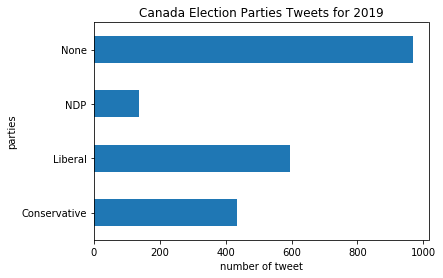

In [38]:
ax1=df_election.groupby(["political party"]).size().plot(kind='barh', stacked=True,ax=plt.gca(),\
                                                    title="Canada Election Parties Tweets for 2019")
ax1.set(xlabel='number of tweet', ylabel='parties')

#### comment：the liberal party mentioned more than the conservetive party and NDP in this dataset

[Text(0, 0.5, 'parties'), Text(0.5, 0, 'number of affiliations')]

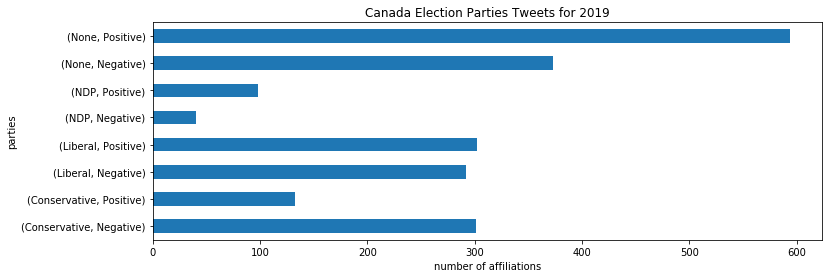

In [39]:
bbb=df_election.groupby(['political party','sentiment']).size()
plt.figure(1,figsize=(12,4))

ax1=bbb.plot(kind='barh', stacked=True,ax=plt.gca(),title="Canada Election Parties Tweets for 2019") #no need to specify for first axis
# plt.subplot(1,2,2)
# ax2=pp_true.plot(kind='barh', stacked=True,ax=plt.gca(),title='sentiment True results ',)
ax1.set(xlabel='number of affiliations', ylabel='parties')
# ax2.set(xlabel='number of comments', ylabel='parties name')


# plt.title("Canada Election Parties Tweets for 2019")
# plt.xlabel("Political Party")
# plt.ylabel("Number of Samples")
# plt.show()

### 2.2.1 question: What can you say about the distribution of the political affiliations of the tweets?
#### comments: the number of the positive tweet related to parties can be considered as the affilations amount. There, the Liberal party has the highest number of affilation around 300, then is the Conservative parties around 120, and the last is the NDP with 30
### 2.2.2 question: Explain how each party is viewed in the public eye based on the sentiment value
#### answer: We can learn from the above graph. First, the Liberal party has the most amount of positive comments, then is Conservative parties. Second, the NDP has postive comments more than negative comments. The Liberal party have almost same negative and positive comments. The Conservative party has more negative comments than positive comments. In summary, more people like Liberal party more than other two. And more people don't like Conservative party.

### 2.3 figures and plots for 2019 Canadian election tweets

In [40]:
liberal_tweets=df_election[df_election['political party']=='Liberal']["text_clean"].values
liberal_tweets=" ".join(liberal_tweets)
type(liberal_tweets)


str

### 2.3.1 word cloud for Liberal from 2019 Canadian election tweets.

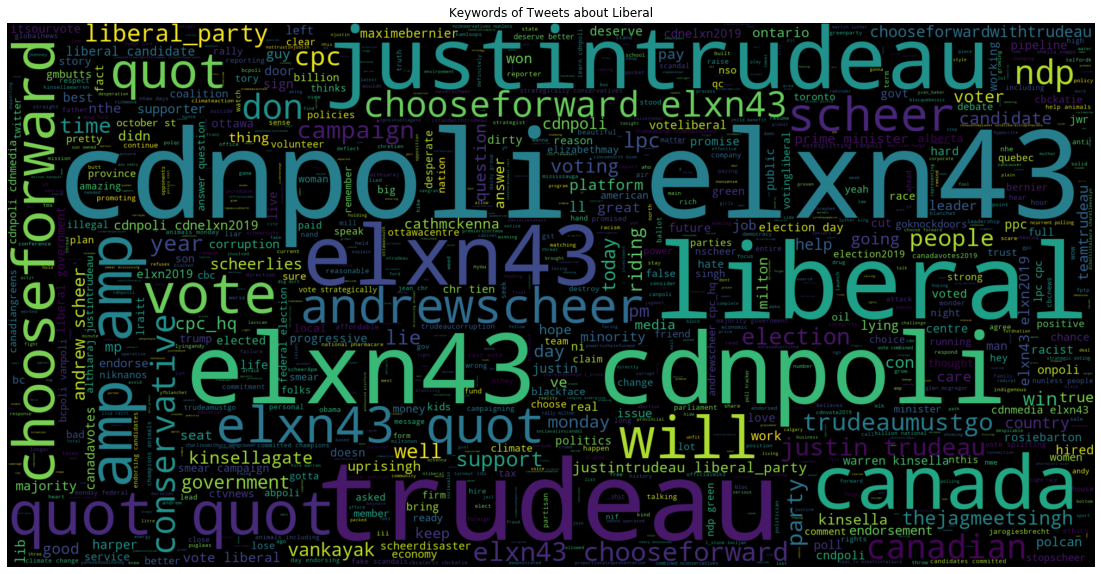

In [41]:
wordcloud = WordCloud(width = 2000, height = 1000, max_words=1000,repeat=False).generate(liberal_tweets)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets about Liberal')
plt.axis("off")
plt.show()

### comment for this plot:
#### World clound can tell us the most important word, and most frequent word for Liberal party is elxn 43, cdnpoli, trudeau, and liberal. We also can see some words related to the conservative party because this world cloud includes some negative comments.

In [42]:
con_tweets=df_election[df_election['political party']=='Conservative']["text_clean"].values
con_tweets=" ".join(con_tweets)
con_tweets=tokenizer.tokenize(con_tweets)
listToStr = ' '.join(map(str, con_tweets))

###  2.3.2 word cloud for Conservative from 2019 Canadian election tweets.

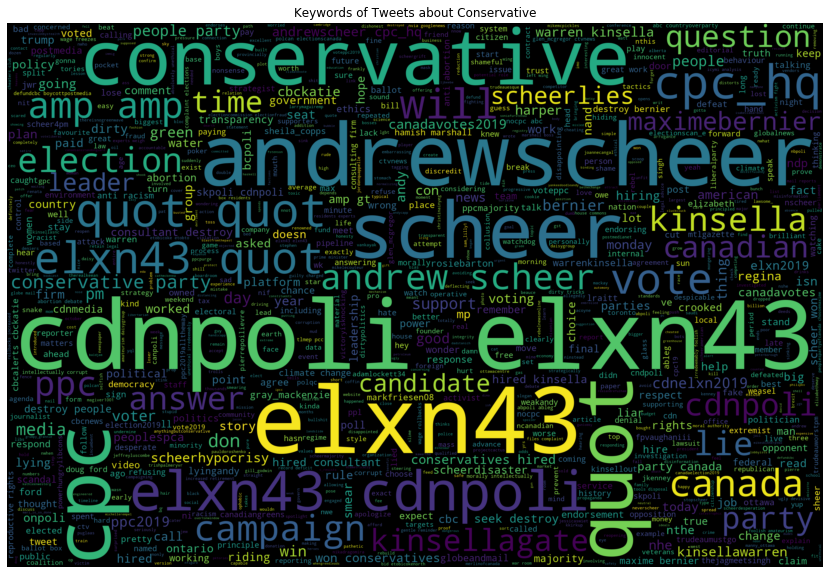

In [43]:
wordcloud = WordCloud(width = 3000, height = 2000, max_words=1000, repeat=False).generate(listToStr)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets about Conservative')
plt.axis("off")
plt.show()

### comment for this plot:
#### Conservarive, andrewscheer and exln43 are the key words. Andrewscheer is the leader, which make senses it appear  frequently. 

###  2.3.3 bar chart ：Sentiment for different parties

In [44]:
df_election['sentiment'].value_counts()

Positive    1127
Negative    1006
Name: sentiment, dtype: int64

In [45]:
df_election.shape

(2133, 5)

In [46]:
df_election[(df_election['political party']=='Conservative')& (df_election['sentiment']=='Positive')].count()

sentiment          133
negative_reason      0
text               133
text_clean         133
political party    133
dtype: int64

In [47]:
df_po=df_election[df_election['sentiment']=='Positive'].groupby(['political party']).size()
df_ne=df_election[df_election['sentiment']=='Negative'].groupby(['political party']).size()



[Text(0, 0.5, 'number of comments'), Text(0.5, 0, 'parties name')]

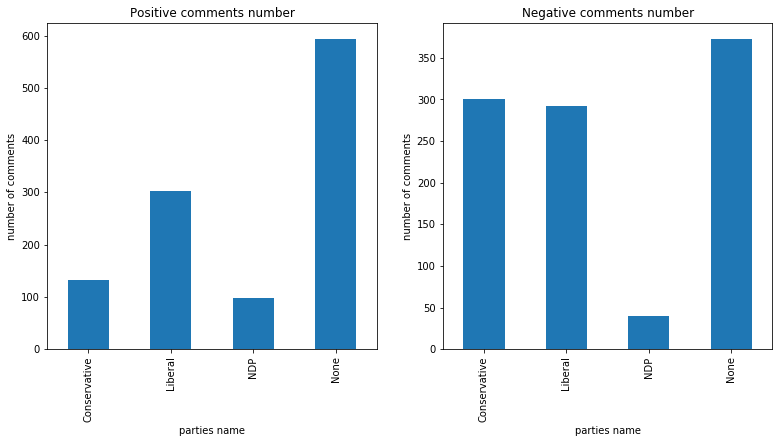

In [48]:

plt.figure(1,figsize=(13,6))
plt.subplot(1,2,1)
ax1=df_po.plot(kind='bar', stacked=True,ax=plt.gca(),title='Positive comments number') #no need to specify for first axis
plt.subplot(1,2,2)
ax2=df_ne.plot(kind='bar', stacked=True,ax=plt.gca(),title='Negative comments number',)
ax1.set(xlabel='parties name', ylabel='number of comments')
ax2.set(xlabel='parties name', ylabel='number of comments')

### piechart for show ratio of each reasons in negative tweets

#### comment: The above graph shows the relation between the name of each political party and their related negative and positive sweet  number. From the graph we can see that the majority of the tweets does not have information related to any party. In addition, the liberal has a little more mentions than the conservative, and the NDP is the least number of mentions from tweets.



In [49]:
reason=df_election['negative_reason'].value_counts()

In [50]:

### piechart for show ratio of each reasons in negative tweets

reason=df_election['negative_reason'].value_counts()

###  2.3.4 piechart for show ratio of each reasons in negative tweets

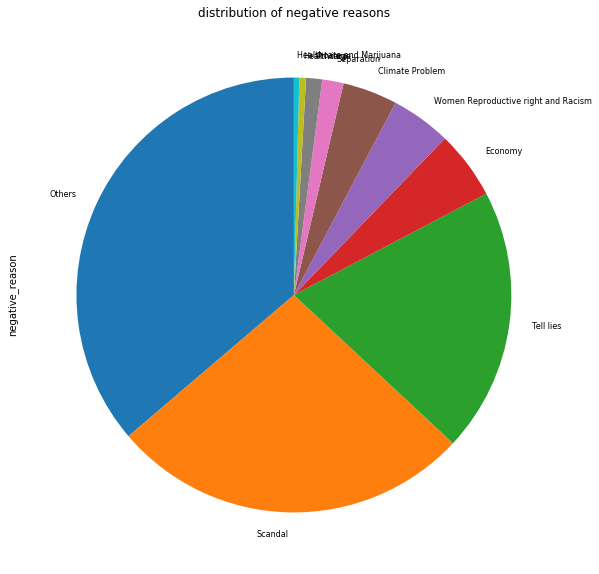

In [51]:

plt=reason.plot.pie(shadow=False, startangle=90,figsize=(10, 10),title='distribution of negative reasons',fontsize=8)
# plt.title('Keywords of Tweets about Liberal')
# plt.axis("equal")
# plt.show()

#### comment: this pie chart shows the distribution of the negative reason. We cannot know what the others reason includes. Then, the largest part is due to scandal, then is tell lies. Therefore, people more concern about the government or the political party tell people truth, and if they are honest with people. 

In [52]:
stemmer=PorterStemmer()
wordnet_lemmatizer= WordNetLemmatizer()


df_sentiment['text_ready']=df_sentiment['text_clean'].apply(lambda data:[stemmer.stem(i) for i in data.split()]) 
df_sentiment['text_ready']=df_sentiment['text_ready'].apply(lambda x: ' '.join(x))
df_sentiment['text_ready']=df_sentiment['text_ready'].apply(lambda data:[wordnet_lemmatizer.lemmatize(i) for i in data.split()]) 

# df_sentiment['text_clean']
df_sentiment['text_ready']=df_sentiment['text_ready'].apply(lambda x: ' '.join(x))

df_sentiment['text_ready']

0         rt diplomtc_immnti realdonaldtrump amp amp pol...
1           chiefy74 damn jealou wanna watch fight love ufc
2                                        listen beatl great
3                         ddlovato shout huge fan t wait cd
4                       salspizza spot ur messag toni repli
                                ...                        
133806                    scottw nice honest don t slingbox
133807    â œ bw_react gopdeb verdict johnkasich win pos...
133808                     amtrack love tho matter hahahaha
133809                      razortv champion leagu free bet
133810                                           beauti day
Name: text_ready, Length: 133797, dtype: object

###  2.3.5 figures and plots for Sentiment.CSV

Text(0, 0.5, 'Number of Samples')

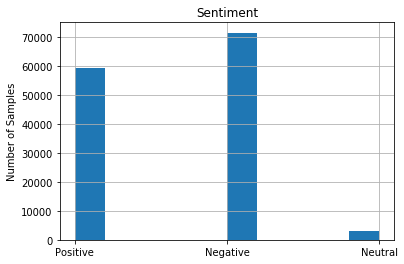

In [53]:

ax=df_sentiment['sentiment'].hist()
ax.set_title("Sentiment")
ax.set_ylabel("Number of Samples")

#### comment:  the sentiment file give the balance dataset, which is good. 

In [54]:
s_tweets=df_sentiment[df_sentiment["sentiment"]=='Positive']
s_tweets=s_tweets['text_clean']
s_tweets=" ".join(s_tweets)
s_tweets=tokenizer.tokenize(s_tweets)
listToStr = ' '.join(map(str, s_tweets))


###  2.3.6 wordcloud for positive sentiment

In [55]:
wordcloud = WordCloud(width = 3000, height = 2000, max_words=1000, repeat=False).generate(listToStr)


(-0.5, 2999.5, 1999.5, -0.5)

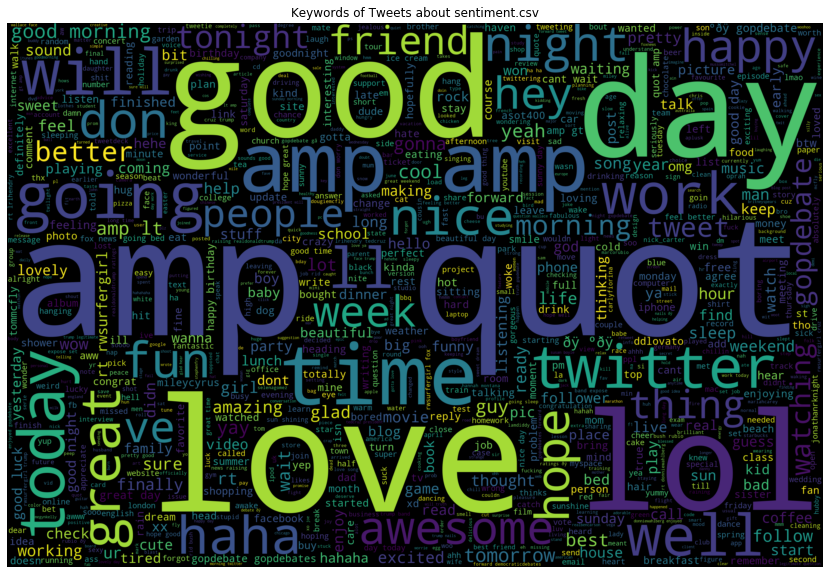

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets about sentiment.csv')
plt.axis("off")

#### comment: love is the most frequency word for positive sentiments in sentiment.csv
### 2.3.7 wordcloud for negative sentiment

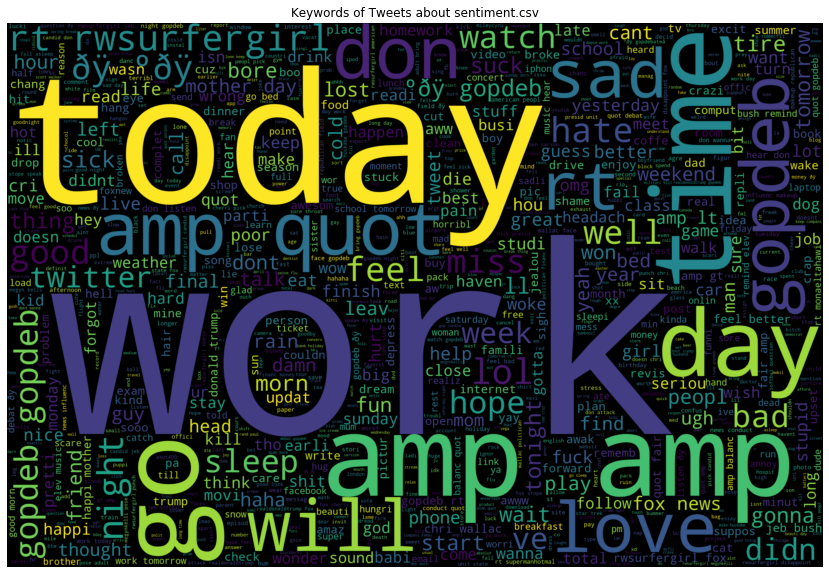

In [58]:
s_tweets=df_sentiment[df_sentiment["sentiment"]=='Negative']
s_tweets=s_tweets['text_ready']
s_tweets=" ".join(s_tweets)
s_tweets=tokenizer.tokenize(s_tweets)
listToStr = ' '.join(map(str, s_tweets))

wordcloud = WordCloud(width = 3000, height = 2000, max_words=1000, repeat=False).generate(listToStr)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets about sentiment.csv')
plt.axis("off")
plt.show()

 #### comment: work and today are the most frequency words for positive sentiments in sentiment.csv

# 3. Model preparation


In [59]:
from sklearn.linear_model import LogisticRegression as lg
from sklearn.naive_bayes import GaussianNB as gb
from sklearn.naive_bayes import MultinomialNB as mnb
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import LinearSVC as lsvm
from sklearn.tree import DecisionTreeClassifier as dt
from  sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
import xgboost as xgb

### 3.1 word frequency (WF) and TF-IDF

#### To encode the tweets into numerical values, I used two methods, tf_idf and word frequency. To implement tfidf, I used sklearn TfidfVectorizer which first vectorize the tweets using CounterVectorize then calculate the tf_idf score, to limit the dimension of feature space I limit the maximum number of features to 1000 after several trials for the next part.  For word frequency mothod, I simply count with CountVectorizer and select the top 1000 most common words as features, then jusge if a word appears in the tweet to vectorize the feature.

In [60]:
### word frequency 


# wordnet_lemmatizer = WordNetLemmatizer()
# stemmer=PorterStemmer()
# word_counter = Counter()


# def corpus_count_words(dataSeries):
#     stop = stopwords.words('english')
#     wordnet_lemmatizer = WordNetLemmatizer()
#     word_counter = Counter()
    
#     for text in dataSeries:
#         words = [wordnet_lemmatizer.lemmatize(i) for i in text.split() if i not in stop]
#         word_counter.update(words)
#     return word_counter


def generate_most_freq(dataFrame,feature_column,label_column,top):

    vectorizer = CountVectorizer(stop_words='english',max_features=top,strip_accents='unicode')
    X = vectorizer.fit_transform(dataFrame[feature_column]).toarray()

    #df_t=tfidf_vector.fit_transform(df_sentiment['text_ready'])
    featureNames=vectorizer.get_feature_names()

    rawDF=pd.DataFrame(X,columns=featureNames)

    Y = dataFrame[label_column]
    return rawDF, Y


def generate_tf_idf(dataFrame,feature_column,label_column,top):
    # transform all text data into TF-IDF features
#     tfidf_vector = TfidfVectorizer(stop_words='english',use_idf=False, norm="l1")
#     X = tfidf_vector.fit_transform(dataFrame[feature_column]).toarray()
#     Y = dataFrame[label_column]
    
    tfidf_vector = TfidfVectorizer(use_idf=True,stop_words='english',use_idf=False, norm="l1",max_features=top,strip_accents='unicode')
    X = tfidf_vector.fit_transform(dataFrame[feature_column]).toarray()

    #df_t=tfidf_vector.fit_transform(df_sentiment['text_ready'])
    featureNames=tfidf_vector.get_feature_names()

    rawDF=pd.DataFrame(X,columns=featureNames)

    Y = dataFrame[label_column]


    return rawDF,Y



### 3.2 generate data using word frequency (WF) and TF-IDF

In [117]:
df_text_freq,dt_target_freq= generate_most_freq(df_sentiment,'text_ready','sentiment',1000)

In [118]:
df_text_tfidf,dt_target_tfidf= generate_tf_idf(df_sentiment,'text_ready','sentiment',1000)

In [63]:
df_text_freq.shape

(133797, 1000)

In [73]:
df_election['text_ready']=df_election['text_clean'].apply(lambda data:[stemmer.stem(i) for i in data.split()]) 
df_election['text_ready']=df_election['text_ready'].ashpply(lambda x: ' '.join(x))
df_election['text_ready']=df_election['text_ready'].apply(lambda data:[wordnet_lemmatizer.lemmatize(i) for i in data.split()]) 

# df_sentiment['text_clean']
df_election['text_ready']=df_election['text_ready'].apply(lambda x: ' '.join(x))

### split data：
#### Two scenarios: word frequency (WF) and TF-IDF

### 3.3 Split the generic tweets from Sentiment.csv file randomly into training data (70%) and test data (30%). 

In [119]:
# word frequency (WF)
X_train_wf, X_test_wf, y_train_wf, y_test_wf = train_test_split(df_text_freq, dt_target_freq, test_size=0.3, random_state=42)
# TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf= train_test_split(df_text_tfidf, dt_target_tfidf, test_size=0.3, random_state=42)



# 4. Model implementation

In [120]:
from sklearn.linear_model import LogisticRegression 
# from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from  sklearn.ensemble import RandomForestClassifier 

# import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics


### 4.1 Logistic Regression

In [121]:
def Log_Reg(train_data, train_labels, test_data, test_labels):

    classifier = LogisticRegression( multi_class='ovr',solver='liblinear')
   
    #multi_class='ovr',solver='liblinear'

    Model_clf = classifier.fit(train_data, train_labels)
    
    train_target_pred = Model_clf.predict(train_data)

    test_target_pred = Model_clf.predict(test_data)
 
    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

In [68]:
tf_train,tf_test=Log_Reg(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('TF-IDF:  the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=Log_Reg (X_train_wf,y_train_wf, X_test_wf, y_test_wf)
print('Word Frequency: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))




TF-IDF:  the accuracy of train: 0.6978442615074154, the accuracy of test 0.6904334828101645 
Word Frequency: the accuracy of train: 0.7119062109612736, the accuracy of test 0.7037867463876433 


### 4.2 Naive Bayes

In [102]:
#MultiNomial NB: It should be used for the features with discrete values like word count 1,2,3
def nb_clf(train_data, train_labels, test_data, test_labels):

    classifier = MultinomialNB()

    Model_clf = classifier.fit(train_data, train_labels)
        
    train_target_pred = Model_clf.predict(train_data)
       
    test_target_pred = Model_clf.predict(test_data)

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
    return train_scores,test_scores

In [103]:
tf_train,tf_test=nb_clf(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('TF-IDF:  the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=nb_clf (X_train_wf,y_train_wf, X_test_wf, y_test_wf)
print('Word Frequency: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))



TF-IDF:  the accuracy of train: 0.6901673126408063, the accuracy of test 0.6818136522172397 
Word Frequency: the accuracy of train: 0.7314132618888145, the accuracy of test 0.6765625 


### 4.3 Decision Tree

In [122]:

def DT_clf(train_data, train_labels, test_data, test_labels):
    classifier = DecisionTreeClassifier(random_state=0,max_depth =20)
    clfModel = classifier.fit(train_data, train_labels)
        # predict using train data
    train_target_pred = clfModel.predict(train_data)
        # predict using test data
    test_target_pred = clfModel.predict(test_data)
    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

In [123]:
tf_train,tf_test=DT_clf(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('TF-IDF:  the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=DT_clf (X_train_wf,y_train_wf, X_test_wf, y_test_wf)
print('Word Frequency: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))



TF-IDF:  the accuracy of train: 0.6134618875257589, the accuracy of test 0.5931489785749875 
Word Frequency: the accuracy of train: 0.6124795797431052, the accuracy of test 0.5954160438465371 


### 4.4 Random Forest

In [124]:
def randomForest_clf(train_data, train_labels, test_data, test_labels):
    classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
    classifier.fit(train_data, train_labels)
        # predict using train data
    train_target_pred = classifier.predict(train_data)
        # predict using test data
    test_target_pred = classifier.predict(test_data)

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

In [125]:
tf_train,tf_test=randomForest_clf(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('TF-IDF:  the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=randomForest_clf (X_train_wf,y_train_wf, X_test_wf, y_test_wf)
print('Word Frequency: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))


### higher max depth, cause the higher accuracy

TF-IDF:  the accuracy of train: 0.6104081915927266, the accuracy of test 0.6059790732436472 
Word Frequency: the accuracy of train: 0.6084649305444334, the accuracy of test 0.6036123567513701 


### 4.5 Adaboost

In [126]:
def adaboost_clf(train_data, train_labels, test_data, test_labels):
    clf = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf.fit(train_data, train_labels)
        # predict using train data
    train_target_pred = clf.predict(train_data)
        # predict using test data
    test_target_pred = clf.predict(test_data)

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

In [127]:
tf_train,tf_test=adaboost_clf(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('TF-IDF:  the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=adaboost_clf (X_train_wf,y_train_wf, X_test_wf, y_test_wf)
print('Word Frequency: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))



TF-IDF:  the accuracy of train: 0.5910396446608369, the accuracy of test 0.5880667663178873 
Word Frequency: the accuracy of train: 0.5958230564720203, the accuracy of test 0.5936721474838067 


#### comment : due to the KNN, ans SVM take too much time. Thus, PCA can decrease the dimension of the dataframe feature. And I will also select part of train and test dataset to test the accuracy of these models. 

In [173]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(X_train_tfidf)
knnTfidf_trainData = pca.transform(X_train_tfidf)
knnTfidf_trainData = pd.DataFrame(knnTfidf_trainData)

pca.fit(X_test_tfidf)
knnTfidf_testData = pca.transform(X_test_tfidf)
knnTfidf_testData = pd.DataFrame(knnTfidf_testData)

pca.fit(X_train_wf)
knnBog_trainData = pca.transform(X_train_wf)
knnBog_trainData = pd.DataFrame(knnBog_trainData)
                                 
pca.fit(X_test_wf)
knnBog_testData = pca.transform(X_test_wf)
knnBog_testData = pd.DataFrame(knnBog_testData)
                                 
knnTfidf_trainData=knnTfidf_trainData[:50000]
knnBog_trainData=knnBog_trainData[:50000]
knnTfidf_testData=knnTfidf_testData[:500]
knnBog_testData=knnBog_testData[:500]


In [186]:
knnTfidf_trainData=knnTfidf_trainData[:5000]
knnBog_trainData=knnBog_trainData[:5000]
knnTfidf_testData=knnTfidf_testData[:50]
knnBog_testData=knnBog_testData[:50]



In [187]:

knnTfidf_trainLabel=y_train_tfidf[:5000]
knnBog_trainLabel=y_train_wf[:5000]
knnTfidf_testLabel=y_test_tfidf[:50]
knnBog_testLabel=y_test_wf[:50]

### 4.6 K-NN

In [181]:
def knn_clf(train_data, train_labels, test_data, test_labels):

    classifier = KNeighborsClassifier(n_neighbors=3)

    Model_clf = classifier.fit(train_data, train_labels)
    train_target_pred = Model_clf.predict(train_data)
    test_target_pred = Model_clf.predict(test_data)

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
    return test_scores

In [182]:
tf_idf_KNN_test=knn_clf(knnTfidf_trainData, knnTfidf_trainLabel, knnTfidf_testData, knnTfidf_testLabel)
wf_KNN_test=knn_clf(knnBog_trainData, knnBog_trainLabel, knnBog_testData, knnBog_testLabel)

In [183]:
print('TF-IDF: the accuracy of test: {} '.format(tf_idf_KNN_test))

print('Word Frequency: the accuracy of test: {} '.format(wf_KNN_test))



TF-IDF: the accuracy of test: 0.558 
Word Frequency: the accuracy of test: 0.538 


### 4.7 SVM

In [185]:
def svm_clf(train_data, train_labels, test_data, test_labels):
    classifier = svm.SVC()
    classifier.fit(train_data, train_labels)
  
    print( "predict using train data")
    train_target_pred = classifier.predict(train_data)

    print(" predict using test data")
    test_target_pred = classifier.predict(test_data)

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

In [188]:
tfSVM_train,tfSVM_test=svm_clf(knnTfidf_trainData, knnTfidf_trainLabel, knnTfidf_testData, knnTfidf_testLabel)
bogSVM_train,bogSVM_test=svm_clf(knnBog_trainData, knnBog_trainLabel, knnBog_testData, knnBog_testLabel)

predict using train data
 predict using test data
predict using train data
 predict using test data


In [189]:
print('TF-IDF: the accuracy of test: {} '.format(tfSVM_test))

print('Word Frequency: the accuracy of test: {} '.format(bogSVM_test))



TF-IDF: the accuracy of test: 0.58 
Word Frequency: the accuracy of test: 0.58 


### 4.8 Evaluate the same model with best performance on the 2019 Canadian elections data.
#### compare the above result, I find the multi-class logistic regression model has the best performance. The Naive bayer has the second best performance. 
#### we can confirm that the logistic regression model with the word frequency method has the highest accuracy score.  TF-IDF:  the accuracy of train: 0.7145917935175266, the accuracy of test 0.6933737641205237  Word Frequency: the accuracy of train: 0.9702660406885759, the accuracy of test 0.6706827309236948 . Then is naive bayers TF-IDF:  the accuracy of train: 0.7051246916963552, the accuracy of test 0.6876721689551346  Word Frequency: the accuracy of train: 0.6767732130845312, the accuracy of test 0.6612675905955712 . We also can find the TF_IDF is better than the Word_ frequency if we compare the test accuracy.



#### But here, I will try two different types of features, word frequency (WF) and TF-IDF for the 2019 Canadian elections data. And i find the word frequency works better for   2019 Canadian elections data

In [138]:

df_election_text_freq,df_election_target_freq= generate_most_freq(df_election,'text_ready','sentiment',1000)

df_election_text_tfidf,df_election_target_tfidf= generate_tf_idf(df_election,'text_ready','sentiment',1000)


In [139]:
tf_train,tf_test=Log_Reg(X_train_tfidf, y_train_tfidf, df_election_text_tfidf, df_election_target_tfidf)
print('TF-IDF:  the accuracy of train: {},the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=Log_Reg(X_train_wf,y_train_wf, df_election_text_freq, df_election_target_freq)
print('Word Frequency: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))



TF-IDF:  the accuracy of train: 0.7095145050556819,the accuracy of test 0.48945147679324896 
Word Frequency: the accuracy of train: 0.7139242128191166, the accuracy of test 0.4927332395686826 


In [140]:
tf_train,tf_test=nb_clf(X_train_tfidf, y_train_tfidf, df_election_text_tfidf, df_election_target_tfidf)
print('TF-IDF:  the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=nb_clf (X_train_wf,y_train_wf,df_election_text_freq, df_election_target_freq)
print('Word Frequency: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))



TF-IDF:  the accuracy of train: 0.694577020404241, the accuracy of test 0.48007501172058137 
Word Frequency: the accuracy of train: 0.6666666666666666, the accuracy of test 0.47773089545241443 


### 4.9 Tune Logistic Regression Model

In [116]:



from sklearn.model_selection import KFold, cross_val_score

k_fold = KFold(n_splits=10)
filterwarnings('ignore')

for C in [0.001,0.01,0.1,0.5,1,5,10, 100]:
    clf = LogisticRegression(solver='liblinear',C=C)
    scores = cross_val_score(clf, X_train_wf, y_train_wf, cv=k_fold, scoring='accuracy')
    print ("Average Score: {}%     (std: {})    with C: {}".format(round(np.mean(scores*100),3),round(np.std(scores),3),C))



Average Score: 63.962%     (std: 0.043)    with C: 0.001
Average Score: 66.915%     (std: 0.034)    with C: 0.01
Average Score: 69.593%     (std: 0.044)    with C: 0.1
Average Score: 69.523%     (std: 0.041)    with C: 0.5
Average Score: 69.455%     (std: 0.042)    with C: 1
Average Score: 69.252%     (std: 0.041)    with C: 5
Average Score: 69.587%     (std: 0.041)    with C: 10
Average Score: 69.521%     (std: 0.041)    with C: 100


comment: based on the results above, the hyperparameter C is chosen as 0.5

### 4.10 visualize the sentiment prediction results and the true sentiment for each of the 3 parties with model of the best performance



In [141]:
def Log_Reg_best (train_data, train_labels, test_data, test_labels):

    classifier = LogisticRegression(multi_class='multinomial',solver='lbfgs',C=0.1)
    

    Model_clf = classifier.fit(train_data, train_labels)
    
    train_target_pred = Model_clf.predict(train_data)

    test_target_pred = Model_clf.predict(test_data)
 
    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
    
     
    return train_scores,test_scores,test_target_pred


In [142]:
tf_train,tf_test,predict_target=Log_Reg_best (X_train_wf,y_train_wf, df_election_text_freq, df_election_target_freq)
print('Word Frequency: the accuracy of test {} '.format(tf_test))




Word Frequency: the accuracy of test 0.49226441631504925 


### 4.11 question:  How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?
#### comment: In conclusion, the model is not good, which only reaches about 49% accuracy to match the sentiment labelled in the 2019 election Canadian. The logistic regression model is good compared to other models using in this question when train and test for sentiment.csv. The best performance model use logistic regression. Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables. Compared to svm, and K-NN, it has the faster speed to train, and predict the more accuracy. Compared to Adaboost and random forest which are both Basic Ensemble Learning model, the logistic regression has higher accuracy. If your data is unbalanced, then random forest may be a better choice. Compared to decision tree, it is still better performance. Decision Trees bisect the space into smaller and smaller regions, whereas Logistic Regression fits a single line to divide the space exactly into two. Of course for higher-dimensional data, these lines would generalize to planes and hyperplanes. The problem is we has a very high dimensional data. If we set the max depth too big, it takes lots of time to calculate.  Compared to naive bayes, the logistic regression model perform still better. Because, Naïve Bayes assumes all the features to be conditionally independent. So, if some of the features are in fact dependent on each other (in case of a large feature space), the prediction might be poor. Logistic regression splits feature space linearly, and typically works reasonably well even when some of the variables are correlated.

#### However, when predicting the testing data from sentiment.csv, the model perform well. When predicting the 2019 election.csv, the results are not acceptable. Because, we do the binary prediction, 49 % mean we don't learn anything from the training data. In other word, the model fail to predict the 2019 canadian election.



In [178]:

df_election['predicted target']=predict_target
pp_predict=df_election.groupby(['political party','predicted target',]).size()
pp_true=df_election[df_election['sentiment']==df_election['predicted target']].groupby(['political party','sentiment',]).size()


In [179]:
aaa=pd.DataFrame(pp_true,columns=['True sentiment from predicted'])
aaa['Origin sentiment']=df_election.groupby(['political party','sentiment']).size().values

### 4.12 visualize the sentiment prediction results and the true sentiment for each of the 3 parties. 

[Text(0, 0.5, 'parties name'), Text(0.5, 0, 'number of comments')]

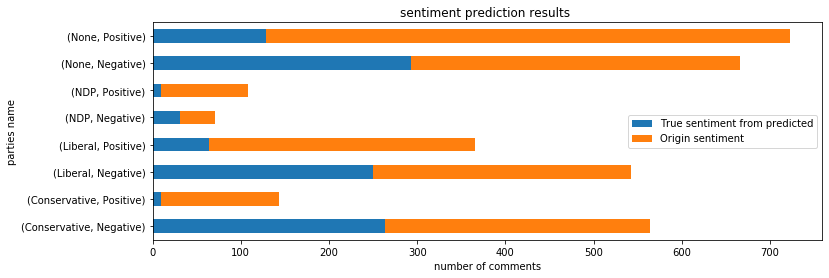

In [180]:
plt.figure(1,figsize=(12,4))

ax1=aaa.plot(kind='barh', stacked=True,ax=plt.gca(),title='sentiment prediction results ') #no need to specify for first axis
# plt.subplot(1,2,2)
# ax2=pp_true.plot(kind='barh', stacked=True,ax=plt.gca(),title='sentiment True results ',)
ax1.set(xlabel='number of comments', ylabel='parties name')
# ax2.set(xlabel='number of comments', ylabel='parties name')




#### plot comments: First, This graph directly presents the prediction results compared to the orignal target. We can see the orange part is the target, and the blue part is the number of correct prediction. The blue part is smaller than the size of orange part. In other words, the model performance is not good.   When predicting the testing data from sentiment.csv, the model perform well. When predicting the 2019 election.csv, the results are not acceptable. Because, we do the binary prediction, 49 % mean we don't learn anything from the training data. In other word, the model fail to predict the 2019 canadian election.
### question: Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.
#### comments: Yes, it is useful for political parites. During the election campaigns, political parites can analyze the comments from tweets to know how many people support them, and how many people dislike them. And they also can analyze the reason, and people belonging to which class. These can help political parties modify their plan, and find the aimed group of people to publicize themselve to gain more support.  However, We need more advanced skill to predict the sentiment. In this assignment, logistic is not powerful enough to get the correct prediction.

In [93]:
df_election_negative=df_election[df_election['sentiment']=='Negative']

### 4.13 Second model
#### steps:
#### 1. drop the Nah value in the negative_reason
#### 2. combine the reason 'Healthcare' with 'Healthcare and Marijuana', because they should be similar.
#### 3. combine the reason 'Scandal' and 'Tell lies', because they all mean the negative information of the parties, people will consider tell lies as the Scandal

In [94]:
df_election_negative.negative_reason.unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

In [95]:
df_election_negative["negative_reason"].replace({'Healthcare': 'Healthcare and Marijuana'}, inplace=True)
df_election_negative.head()
df_election_negative.negative_reason
df_election_negative.negative_reason.unique()
#,'Tell lies':'Scandal','Privilege':'Scandal'

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare and Marijuana', 'Separation'], dtype=object)

### 4.14 split negative 2019 Canadian elections tweets into training data (70%) and test data (30%)

In [96]:
text_freq,target_freq= generate_most_freq(df_election_negative,'text_clean','negative_reason',200)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(text_freq, target_freq, test_size=0.7, random_state=0)
X_train_2.shape

(301, 200)

### 4.15 Prepare Multi-class model:

In [97]:
def Log_Reg_2(train_data, train_labels, test_data, test_labels):

    classifier = LogisticRegression(multi_class='multinomial',solver='lbfgs')

    Model_clf = classifier.fit(train_data, train_labels)
    
    train_target_pred = Model_clf.predict(train_data)

    test_target_pred = Model_clf.predict(test_data)
 
    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores


def DT_clf_2(train_data, train_labels, test_data, test_labels):
    classifier = DecisionTreeClassifier(random_state=0,max_depth =20)
    clfModel = classifier.fit(train_data, train_labels)
        # predict using train data
    train_target_pred = clfModel.predict(train_data)
        # predict using test data
    test_target_pred = clfModel.predict(test_data)
    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

def randomForest_clf_2(train_data, train_labels, test_data, test_labels):
    classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
    classifier.fit(train_data, train_labels)
        # predict using train data
    train_target_pred = classifier.predict(train_data)
        # predict using test data
    test_target_pred = classifier.predict(test_data)

    train_scores=metrics.accuracy_score(train_labels, train_target_pred)
    test_scores=metrics.accuracy_score(test_labels, test_target_pred)   
        
 
    return train_scores,test_scores

### 4.16 choose three algorithms to train and test

In [98]:

tf_train,tf_test=Log_Reg_2 (X_train_2,y_train_2, X_test_2, y_test_2)
print('Word Frequency with logistic regression: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=randomForest_clf_2 (X_train_2,y_train_2, X_test_2, y_test_2)
print('Word Frequency with Random Forest: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=DT_clf_2 (X_train_2,y_train_2, X_test_2, y_test_2)
print('Word Frequency with Decision Tree: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))





Word Frequency with logistic regression: the accuracy of train: 0.8538205980066446, the accuracy of test 0.48226950354609927 
Word Frequency with Random Forest: the accuracy of train: 0.6877076411960132, the accuracy of test 0.5078014184397163 
Word Frequency with Decision Tree: the accuracy of train: 0.7508305647840532, the accuracy of test 0.5234042553191489 


#### comment:
#### The results seem that we fail to predict the correct reason of negative sentiments. We can see the best performance modelDecision Tree: gives us 52% accuracy on testing, which means the prediction is not very accurate. We cannot trust this model to truely find the reason of negative sentiments. 
### The reason that model fail to predict the correct negative reasons may be:  
#### the model is overfitting the train data. we can find the training accuracy is about  75 percent, which is a pretty high accuracy. However, the accuracy of testing data is only 52%. In the training data, and testing data, we choose 200 different word as the feature. We have too many feature, but 301 training data in total. Therefore, we can reduce the word numbers, and reset the training data, and test data. Or we should use more training data to predict.
#### therefore, we need to prepare more data, and then we need to select the features. We need to find more informational words to be our features.


#### example 1:


In [99]:
text_freq,target_freq= generate_most_freq(df_election_negative,'text_clean','negative_reason',30)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(text_freq, target_freq, test_size=0.7, random_state=0)

# text_freq,target_freq= generate_most_freq(df_election_negative,'text_clean','negative_reason',500)



In [100]:
X_test_2.shape

(705, 30)

In [101]:

tf_train,tf_test=Log_Reg_2 (X_train_2,y_train_2, X_test_2, y_test_2)
print('Word Frequency with logistic regression: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=randomForest_clf_2 (X_train_2,y_train_2, X_test_2, y_test_2)
print('Word Frequency with Random Forest: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))
tf_train,tf_test=DT_clf_2 (X_train_2,y_train_2, X_test_2, y_test_2)
print('Word Frequency with Naive Bayers: the accuracy of train: {}, the accuracy of test {} '.format(tf_train,tf_test))






Word Frequency with logistic regression: the accuracy of train: 0.5481727574750831, the accuracy of test 0.44397163120567373 
Word Frequency with Random Forest: the accuracy of train: 0.717607973421927, the accuracy of test 0.4524822695035461 
Word Frequency with Naive Bayers: the accuracy of train: 0.8239202657807309, the accuracy of test 0.37446808510638296 
